In [1]:
from matplotlib import pyplot as plot
from tqdm.notebook import tqdm
from itertools import product

from scipy.stats import gamma, norm, laplace
from random import sample
import numpy, ray, gc

%matplotlib inline

In [2]:
class distribution():
    def __init__(self, name, sampler, density):
        self.name = name
        self.sampler, self.conditional_density = sampler, density

In [3]:
# Standard symmetric, mean-zero noise

def gaussian_noise(location, epsilon):
    return location + numpy.random.normal(loc = [0, 0], scale = 1 / epsilon )

def gaussian_conditional(location, conditional, epsilon):
    difference = location - conditional
    return numpy.prod( norm.pdf(difference, scale = 1 / epsilon) )

gaussian = distribution("Gaussian Noise", gaussian_noise, gaussian_conditional)

def laplacian_noise(location, epsilon):
    return location + numpy.random.laplace(loc = [0, 0], scale = 1 / epsilon )

def laplacian_conditional(location, conditional, epsilon):
    difference = location - conditional
    return numpy.prod( laplace.pdf(difference, scale = 1 / epsilon) )

laplacian = distribution("Laplacian Noise", laplacian_noise, laplacian_conditional)

In [4]:
# State-of-the-art noise for location-based differential privacy

def geo_noise(location, epsilon):
    theta, r = numpy.random.uniform(0, 2 * numpy.pi), gamma.ppf(numpy.random.uniform(0, 1), 2, scale = (1 / epsilon))
    x, y = r * numpy.cos(theta), r * numpy.sin(theta)
    return location + numpy.array([x, y])

def geo_conditional(location, conditional, epsilon):
    x, y = location - conditional
    r = numpy.sqrt(x ** 2 + y ** 2)
    return gamma.pdf(r, 2, scale = 1 / epsilon) * (0.5 / numpy.pi)

geo_indistinguishable = distribution("Geo-Indistinguishability", geo_noise, geo_conditional)

In [5]:
# Location-based k-Anonymity analogues

def square_cloak(location, epsilon):
    cloaked_x = round( location[0] * epsilon ) / epsilon
    cloaked_y = round( location[1] * epsilon ) / epsilon
    return ( cloaked_x + (0.5 / epsilon), cloaked_y + (0.5 / epsilon) )

def square_conditional(location, conditional, epsilon):
    return (1 / 25) if all(numpy.equal( square_cloak(location, epsilon), conditional )) else 0

square_cloaking = distribution("Square Cloaking", square_cloak, square_conditional)

In [6]:
privacy_schemes = [ gaussian, laplacian, geo_indistinguishable, square_cloaking ]

In [7]:
def distance(location, center):
    return numpy.sqrt( (location[0] - center[0]) ** 2 + (location[1] - center[1]) ** 2 )

def transpose(nested):
    return list(zip(* nested))

In [8]:
class user:
    def __init__(self, server, inertia = 1):
        self.space = server.space
        self.location_distr = self.centered_distribution( inertia )
        self.location_distr = self.location_distr / numpy.sum(self.location_distr)
        
    def centered_distribution(self, inertia):
        center  = self.space[ numpy.random.randint(0, len(self.space)) ]
        initial = [ numpy.random.uniform(0, 2) / (distance(L, center) + 1) for L in self.space ]
        initial = numpy.array(initial) ** inertia
        return numpy.round( initial / numpy.sum( initial ), decimals = 3 )
        
    def sample(self, epochs):
        index = numpy.random.choice( len(self.space), size = epochs, p = self.location_distr )
        return [ self.space[i] for i in index ]

In [78]:
class server:
    def __init__(self, length = 75, count = 100, epochs = 250):
        self.space = list( map(numpy.array, product(range(length), repeat = 2 )) )
        self.users = [ user(self, numpy.random.uniform(1, 3) ) for i in range(count) ]
        self.length, self.epochs = length * length, epochs
        
        self.samples = [ u.sample(epochs) for u in tqdm(self.users) ]
        self.noisy_samples = {}
        
    def introduce_privacy(self, epsilon):
        self.epsilon = epsilon
        for scheme in tqdm(privacy_schemes):
            sample_user = lambda user: [ scheme.sampler(location, self.epsilon) for location in user ]
            heartbeats  = [ sample_user(user) for user in self.samples ]            
            self.noisy_samples[ scheme.name ] = heartbeats
        
    def average_accuracy(self, scheme):
        accuracy = 0
        sample_size = ( sample( range(len(self.users)), 10 ), sample( range(self.epochs), 10 ) )
        for user, epoch in product(* sample_size):
                center, noisy_center = self.samples[user][epoch], self.noisy_samples[scheme.name][user][epoch]
                accuracy = accuracy + self.accuracy( center, noisy_center, epoch, scheme )
        return accuracy / 100
                
    def accuracy(self, center, noisy_center, epoch, scheme):
        locations = transpose(self.samples)[epoch]
        noisy_locations = transpose(self.noisy_samples[scheme.name])[epoch]
        
        original = set([ x for x in range(len(locations)) if distance( locations[x], center) < 10 ] )
        private  = set([ x for x in range(len(noisy_locations)) if distance( noisy_locations[x], noisy_center ) < 10 ])
        
        return len(original.intersection( private )) / len(original.union( private ))

In [79]:
class semi_honest(server):
    def average_predictive_power(self, scheme):
        results = [ self.noisy_estimates(scheme, i) for i in tqdm(range(len(self.samples))) ]
        return numpy.mean( results, axis = 0 )
    
    def noisy_estimates(self, scheme, user):
        user_heartbeats = self.noisy_samples[scheme.name][user]
        estimates = [ numpy.ones(( self.length, )) / self.length ]

        for i in tqdm(range(self.epochs)):
            estimates.append( self.update_MLE(estimates[-1], user_heartbeats[i], scheme) )
            estimates[-2] = estimates[-2] ** 2
            estimates[-2] = estimates[-2] / numpy.sum(estimates[-2])

        estimates[-1] = estimates[-1] ** 2
        estimates[-1] = estimates[-1] / numpy.sum(estimates[-1])
        
        true = self.users[user].location_distr
        return numpy.fromiter( map( lambda x: self.bhattacharyya(x, true), estimates ), dtype = float )
        
    def update_MLE(self, distribution, heartbeat, scheme):
        conditional = numpy.array([ scheme.conditional_density(x, heartbeat, self.epsilon) for x in self.space ])
        distribution = distribution + conditional
        return distribution
        
    def bhattacharyya(self, estimate, true):
        return numpy.sum(numpy.sqrt(estimate * true))

In [85]:
def compare_scheme_accuracy(server, save = False):
    endogenous = numpy.arange(0.025, 1.025, 0.025)
    _exogenous = []
    
    for epsilon in tqdm(endogenous):
        server.introduce_privacy(epsilon)
        _exogenous.append([ server.average_accuracy(scheme) for scheme in privacy_schemes ])
        gc.collect()
        
    _exogenous = zip( transpose(_exogenous), privacy_schemes )
    for exogenous, scheme in _exogenous:
        plot.plot(endogenous, exogenous, label = scheme.name )

    plot.legend()
    plot.savefig(save) if save else plot.show()

In [86]:
def compare_scheme_privacy(server, save = False):
    endogenous = range(server.epochs + 1)
    
    for scheme in privacy_schemes:
        plot.plot(endogenous, server.average_predictive_power(scheme), label = scheme.name)
        gc.collect()

    plot.legend()
    plot.savefig(save) if save else plot.show()

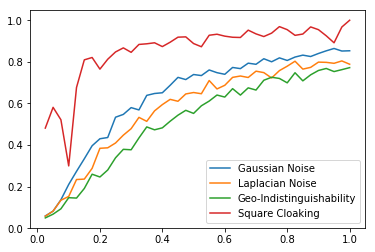

In [88]:
USGS = semi_honest(length = 250, count = 500, epochs = 250)
compare_scheme_accuracy(USGS)

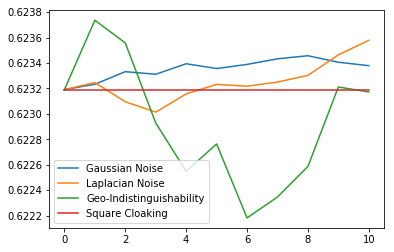

In [90]:
USGS.introduce_privacy(0.02)
compare_scheme_privacy(USGS)

In [ ]:
plot.scatter( * zip(* USGS.users[0].space), s = USGS.users[0].location_distr * 100 )
plot.show()

In [ ]:
heartbeats = USGS.noisy_samples["Geo-Indistinguishability"][0]
zero = numpy.zeros(( USGS.length, ))

estimate = numpy.sum([ USGS.update_MLE(zero, heartbeats[i], geo_indistinguishable) for i in tqdm(range(USGS.epochs))], axis = 0)
estimate = estimate / sum(estimate)

plot.scatter( * zip(* USGS.users[0].space), s = estimate * 100 )
plot.show()

In [ ]:
heartbeats = USGS.noisy_samples["Square Cloaking"][0]
zero = numpy.zeros(( USGS.length, ))

estimate = numpy.sum([ USGS.update_MLE(zero, heartbeats[i], square_cloaking) for i in tqdm(range(USGS.epochs))], axis = 0)
estimate = estimate / sum(estimate)

plot.scatter( * zip(* USGS.users[0].space), s = estimate * 100 )
plot.show()